In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl

In [ ]:
# Define parameters
dt = 1
kappa = dt * 0.01 
phi_a = dt * 15.0
phi_b = dt * 15.0
Delta_a = dt * 0.01
Delta_b = dt * 0.01
gamma_a = 0
gamma_b = 0
ref_price_a = 100 
ref_price_b = 100
std_price_a = 1
std_price_b = 1
price_bins = np.linspace(
        min(ref_price_a, ref_price_b) - 5 * std_price_b,
        max(ref_price_a, ref_price_b) + 5 * std_price_a,
        500)
price_midpoints = 0.5 * (price_bins[1:] + price_bins[:-1])
dp = price_midpoints[1] - price_midpoints[0]

In [3]:
price_bins_int = np.linspace(
        min(ref_price_a, ref_price_b) - 5 * std_price_b,
        max(ref_price_a, ref_price_b) + 5 * std_price_a,
        1000)
price_midpoints_int = 0.5 * (price_bins_int[1:] + price_bins_int[:-1])
dp_int = price_midpoints_int[1] - price_midpoints_int[0]

In [ ]:
# Set global style
sns.set(style="ticks", context="paper")
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math text
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['lines.linewidth'] = 2

def plot(n_a_initial, n_b_initial, na_eq_dist, nb_eq_dist, n_a, n_b):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Metrópolis results 
    ax.plot(price_midpoints, n_a, 
            alpha=0.6, label=r'$n_a(p)$ reached distribution', color='firebrick', linestyle='-', linewidth=2)
    ax.plot(price_midpoints, n_b, 
            alpha=0.6, label=r'$n_b(p)$ reached distribution', color='navy', linestyle='-', linewidth=2)

    # Master Equation solutions (Equilibrium)
    ax.plot(price_midpoints_int, na_eq_dist, 
            alpha=1, label=r'$n_a(p)$ target distribution', color='darkorange', linestyle='-', linewidth=3)
    ax.plot(price_midpoints_int, nb_eq_dist, 
            alpha=1, label=r'$n_b(p)$ target distribution', color='teal', linestyle='-', linewidth=3)

    # Initial conditions
    ax.plot(price_midpoints, n_a_initial, 
            alpha=0.7, label=r'$n_a(p)$ and $n_b(p)$ initial distributions', color='black', linestyle='-', linewidth=1.5)

    # Final touches
    ax.set_title('Functional minimization', fontsize=20)
    ax.set_xlabel('Price', fontsize=16)
    ax.set_xticks(np.arange(95, 106, step=2))
    ax.set_ylabel('Particle Ammount', fontsize=16)
    ax.set_ylim(top=270)
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=False)
    ax.grid(True, linestyle='--', alpha=0.6)
    sns.despine(trim=True)
    plt.tight_layout()

    plt.savefig("images/Conexion/Metropolis mercado informal ingles.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

def P_a(p): #valores de las gaussianas iniciales de los precios
    return np.exp(-0.5 * ((p - ref_price_a) / std_price_a) ** 2) / (std_price_a * np.sqrt(2 * np.pi))

def P_b(p):
    return np.exp(-0.5 * ((p - ref_price_b) / std_price_b) ** 2) / (std_price_b * np.sqrt(2 * np.pi))

P_a_values = P_a(price_midpoints)
P_b_values = P_b(price_midpoints) 

def metropolis_optimized(n_a_initial, n_b_initial, n_steps, interaction, beta):
    global P_a_values, P_b_values

    time = []
    gran_potencial = []
    potencial_int_inicial = 0

    # Precompute constants for delta_E calculations
    phi_a_div = phi_a / (1 - gamma_a)
    Delta_a_div = Delta_a / (1 - gamma_a)
    phi_b_div = phi_b / (1 - gamma_b)
    Delta_b_div = Delta_b / (1 - gamma_b)
    
    # Initialize arrays and their logarithms
    n_a = n_a_initial.copy()
    n_b = n_b_initial.copy()
    log_n_a = np.log(n_a)
    log_n_b = np.log(n_b)
    
    for step in range(n_steps):

        time.append(step)

        # Perturb n_a
        idx = np.random.randint(len(n_a))
        old_val = n_a[idx]
        delta = np.random.choice([0.99, 1.01])
        new_val = old_val * delta
        new_val = max(new_val, 0.001)  # Ensure positivity
        delta_n = new_val - old_val
        
        # if interactions
        if interaction:
            sum_n_b_after = np.sum(n_b[idx:])
            delta_term1 = kappa * delta_n * sum_n_b_after * dp**2
        else:
            delta_term1 = 0
        
        # Compute delta_log
        new_log_val = np.log(new_val)
        delta_log = new_log_val - log_n_a[idx]
        delta_term2_a = -(phi_a_div * P_a_values[idx] * delta_log - Delta_a_div * delta_n) * dp
        delta_E = delta_term1 + delta_term2_a
        
        # Accept or reject the move
        if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
            n_a[idx] = new_val
            log_n_a[idx] = new_log_val  # Update log array
        
        # Perturb n_b
        idx = np.random.randint(len(n_b))
        old_val = n_b[idx]
        delta = np.random.choice([0.99, 1.01])
        new_val = old_val * delta
        new_val = max(new_val, 0.001)
        delta_n = new_val - old_val
        
        if interaction:
            sum_n_a_before = np.sum(n_a[:idx+1])
            delta_term1 = kappa * delta_n * sum_n_a_before * dp**2
        else:
            delta_term1 = 0
        
        # Compute delta_log 
        new_log_val = np.log(new_val)
        delta_log = new_log_val - log_n_b[idx]
        delta_term2_b = -(phi_b_div * P_b_values[idx] * delta_log - Delta_b_div * delta_n) * dp
        delta_E = delta_term1 + delta_term2_b
        
        # Accept or reject the move
        if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
            n_b[idx] = new_val
            log_n_b[idx] = new_log_val 
    
    return n_a, n_b

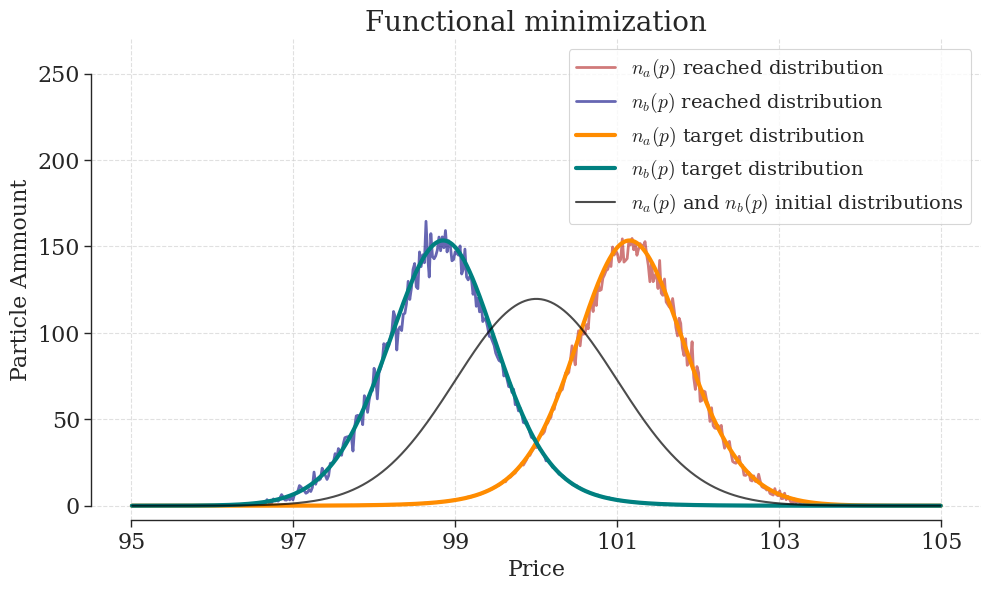

In [ ]:
n_steps = 5000000
interaction = True
beta = 10000

with open("resources\\Simulacion mercado informal\\dist_eq_n_a_integral.pkl", 'rb') as f:
    n_a_eq_dist = pickle.load(f)
   
with open("resources\\Simulacion mercado informal\\dist_eq_n_b_integral.pkl", 'rb') as f:
    n_b_eq_dist = pickle.load(f)
   
n_a_initial = 300 * P_a_values
n_b_initial = 300 * P_a_values

def replace_zeros_with_small_value(array):

    modified_array = array.copy().astype(np.float32)
    modified_array[modified_array == 0] = 0.1
    
    return modified_array

n_a_initial = replace_zeros_with_small_value(n_a_initial)
n_b_initial = replace_zeros_with_small_value(n_b_initial)
n_a_eq_dist = replace_zeros_with_small_value(n_a_eq_dist)
n_b_eq_dist = replace_zeros_with_small_value(n_b_eq_dist)

n_a, n_b = metropolis_optimized(n_a_initial, n_b_initial, n_steps, interaction,beta)

plot(n_a_initial, n_b_initial, n_a_eq_dist, n_b_eq_dist, n_a, n_b)